# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils

# Transformations

In [2]:
data_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Load dataset

In [3]:
train = datasets.MNIST('/home/jd/Desktop/EVA5/secession5/', train=True, download=True,transform=data_transforms)
test = datasets.MNIST('/home/jd/Desktop/EVA5/secession5/', train=True, download=True,transform=data_transforms)

# Dataloaders: Test/Train dataset

In [4]:
SEED = 3

# is cuda available
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

# dataloader arguments
dataloader_args = dict(shuffle = True, batch_size = 128, num_workers = 4,pin_memory = True) if cuda else dict(shuffle = True, batch_size = 64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, ** dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics & Sample Data

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])


/home/jd/anaconda3/envs/eva5/lib/python3.8/site-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)
torch.Size([128, 1, 28, 28])
torch.Size([128])


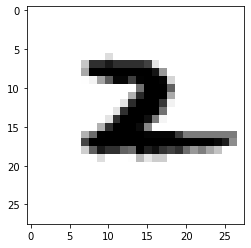

In [5]:
# converting array into numpy from tensor
train_data = train.train_data
train_data = train.transform(train.train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[52].numpy().squeeze(), cmap='gray_r')


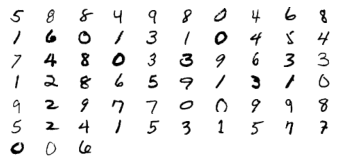

In [6]:
figure = plt.figure()
num_of_images = 63
for index in range(1, num_of_images + 1):
    plt.subplot(10, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Mean & Std Values to Normalize dataset

In [7]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('/home/jd/Desktop/EVA5/secession5/', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

/home/jd/anaconda3/envs/eva5/lib/python3.8/site-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


# Basic Model

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # input_size = 28 output_size = 26 receptive_field = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # input_size = 26 output_size = 24 receptive_field = 5
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(15),
            nn.ReLU()
        ) # input_size = 24 output_size = 22 receptive_field = 7

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # input_size = 22 output_size = 11 receptive_field = 9
        
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # input_size = 11 output_size = 11 receptive_field = 9

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # input_size = 11 output_size = 9 receptive_field = 13
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # input_size = 9 output_size = 7 receptive_field = 17
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # input_size = 7 output_size = 5 receptive_field = 21
        # OUTPUT BLOCK
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(5, 5), padding=0, bias=False),
        ) # input_size = 5 output_size = 1  receptive_field = 29
        

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params

In [9]:
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1,28,28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 15, 22, 22]           1,350
       BatchNorm2d-8           [-1, 15, 22, 22]              30
              ReLU-9           [-1, 15, 22, 22]               0
        MaxPool2d-10           [-1, 15, 11, 11]               0
           Conv2d-11           [-1, 10, 11, 11]             150
      BatchNorm2d-12           [-1, 10, 11, 11]              20
             ReLU-13           [-1, 10, 11, 11]               0
           Conv2d-14             [

#Training & Testing

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Train & Test model

In [11]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.06958507001399994 Batch_id=468 Accuracy=93.55: 100%|██████████| 469/469 [00:15<00:00, 29.50it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0706, Accuracy: 58767/60000 (97.94%)

EPOCH: 1


Loss=0.03679026663303375 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:15<00:00, 29.32it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0497, Accuracy: 59062/60000 (98.44%)

EPOCH: 2


Loss=0.025155723094940186 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:16<00:00, 28.06it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0446, Accuracy: 59176/60000 (98.63%)

EPOCH: 3


Loss=0.015902573242783546 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:17<00:00, 27.41it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 59417/60000 (99.03%)

EPOCH: 4


Loss=0.027112679556012154 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:16<00:00, 27.69it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 59448/60000 (99.08%)

EPOCH: 5


Loss=0.014252168126404285 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:17<00:00, 27.45it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 59507/60000 (99.18%)

EPOCH: 6


Loss=0.03679681196808815 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:17<00:00, 27.43it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 59588/60000 (99.31%)

EPOCH: 7


Loss=0.00889240950345993 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:17<00:00, 27.43it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 59588/60000 (99.31%)

EPOCH: 8


Loss=0.012230493128299713 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:17<00:00, 27.52it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 59648/60000 (99.41%)

EPOCH: 9


Loss=0.007029946427792311 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:17<00:00, 27.43it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 59625/60000 (99.38%)

EPOCH: 10


Loss=0.011621608398854733 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:16<00:00, 27.62it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 59690/60000 (99.48%)

EPOCH: 11


Loss=0.0021488042548298836 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:16<00:00, 28.78it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0140, Accuracy: 59764/60000 (99.61%)

EPOCH: 12


Loss=0.00424998952075839 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:15<00:00, 29.44it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0140, Accuracy: 59743/60000 (99.57%)

EPOCH: 13


Loss=0.010890793055295944 Batch_id=468 Accuracy=99.54: 100%|██████████| 469/469 [00:15<00:00, 29.47it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0144, Accuracy: 59732/60000 (99.55%)

EPOCH: 14


Loss=0.01596701703965664 Batch_id=468 Accuracy=99.57: 100%|██████████| 469/469 [00:09<00:00, 52.06it/s]  



Test set: Average loss: 0.0148, Accuracy: 59722/60000 (99.54%)



# Ploting model result

Text(0.5, 1.0, 'Test Accuracy')

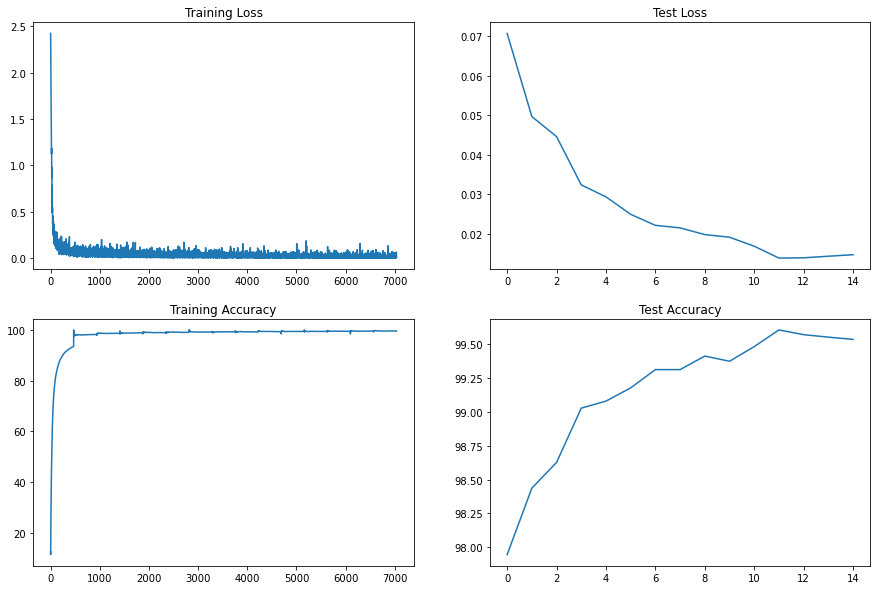

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")